In [1]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklego.preprocessing import RepeatingBasisFunction

# Functions

In [2]:
def calc_cosine_feature(xs, period):
    '''Maps xs to Unit circle'''
    xs = xs * 2*np.pi / period  
    return np.cos(xs) 


def calc_sine_feature(xs, period):
    '''Maps xs to Unit circle'''
    xs = xs * 2*np.pi / period  
    return np.sin(xs)


def fit_predict(X_train):
    model = LinearRegression().fit(X_train[:TRAIN_END], y[:TRAIN_END])
    return model.predict(X_train)


def make_forecast_plot(df, y, yhat, title):
    df[[y, yhat]].plot(figsize=(16,4), title=title)
    plt.axvline(date(2020, 1, 1), c="m", linestyle="--")


In [3]:
np.random.seed(42)

# Data Generation

Let's generate daily dataset

In [4]:
range_of_dates = pd.date_range(start="2017-01-01", end="2020-12-30")
df = pd.DataFrame(index=range_of_dates)

df["day_nr"] = range(df.shape[0])
df["day_of_year"] = df.index.day_of_year

df.head()

,day_nr,day_of_year
2017-01-01,0,1
2017-01-02,1,2
2017-01-03,2,3
2017-01-04,3,4
2017-01-05,4,5


In [5]:
TRAIN_END = 3 * 365

# Signal generation

Let's take a look at different signal transformations

In [6]:
signal_1 = np.sin(df["day_nr"] / 365 * 2*np.pi)  # original signal
signal_2 = 1 + np.sin(df["day_nr"] / 365 * 2*np.pi)  # amplitude shift
signal_3 = 2*np.sin(df["day_nr"] / 365 * 2*np.pi)  # amplitude extension
signal_4 = np.sin(df["day_nr"] / 365 * 2*np.pi + np.pi/4)  # phase shift
signal_5 = np.sin(df["day_nr"] / 365 * 2*np.pi / 2)  # phase extension

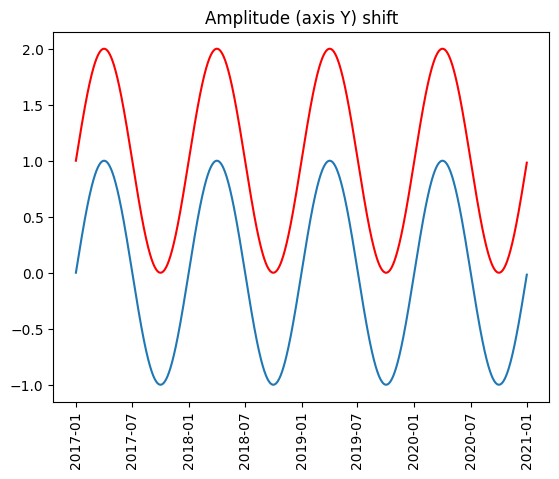

In [7]:
plt.plot(df.index, signal_1)
plt.plot(df.index, signal_2, color='r')
plt.xticks(rotation=90)
plt.title('Amplitude (axis Y) shift')
plt.show();

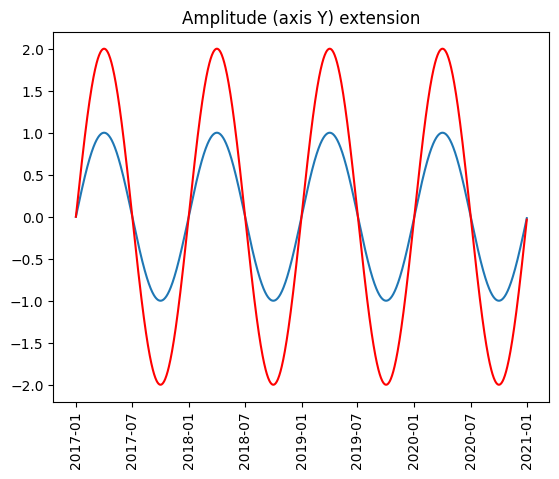

In [8]:
plt.plot(df.index, signal_1)
plt.plot(df.index, signal_3, color='r')
plt.xticks(rotation=90)
plt.title('Amplitude (axis Y) extension')
plt.show();

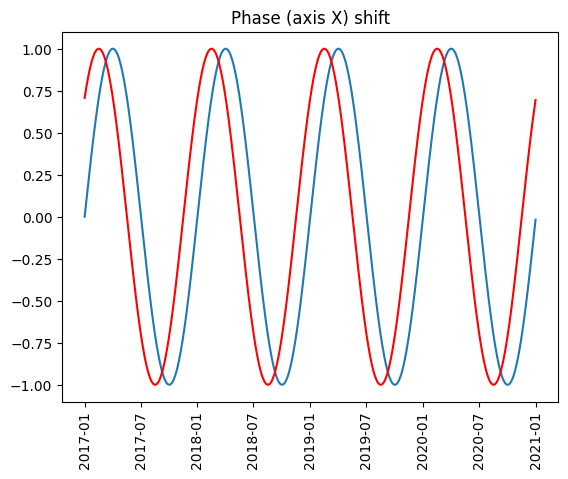

In [9]:
plt.plot(df.index, signal_1)
plt.plot(df.index, signal_4, color='r')
plt.xticks(rotation=90)
plt.title('Phase (axis X) shift')
plt.show();

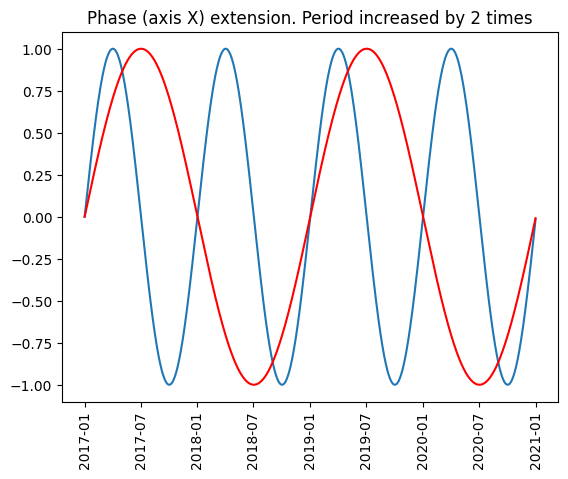

In [10]:
plt.plot(df.index, signal_1)
plt.plot(df.index, signal_5, color='r')
plt.xticks(rotation=90)
plt.title('Phase (axis X) extension. Period increased by 2 times')
plt.show();

#### Let's generate the components of the target

In [11]:
signal_1 = 3 + 4 * np.sin(df["day_nr"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(df["day_nr"] / 365 * 4 * np.pi + 365/2)

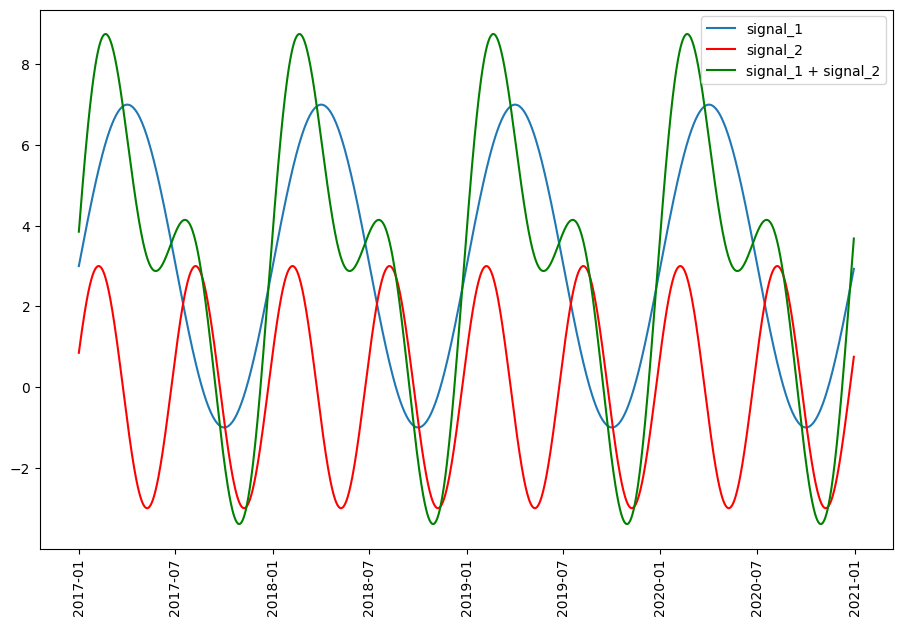

In [12]:
plt.figure(figsize=(11, 7))
plt.plot(df.index, signal_1)
plt.plot(df.index, signal_2, color='r')
plt.plot(df.index, signal_1 + signal_2, color='g')

plt.xticks(rotation=90)
plt.legend(['signal_1', 'signal_2', 'signal_1 + signal_2'])
plt.show();

Let's add some noize and combine them to get the target series

In [13]:
noise = np.random.normal(0, 0.85, df.shape[0])

# combine them to get the target series
y = signal_1 + signal_2 + noise

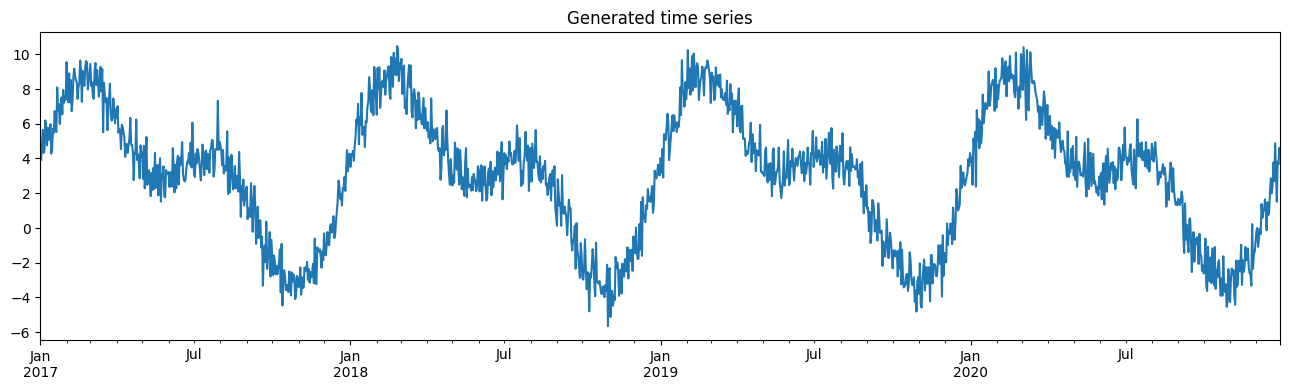

In [14]:
# plot
y.plot(figsize=(16,4), title="Generated time series");

In [15]:
df['y'] = y

In [16]:
df.head()

,day_nr,day_of_year,y
2017-01-01,0,1,4.273237
2017-01-02,1,2,3.900877
2017-01-03,2,3,4.735163
2017-01-04,3,4,5.644148
2017-01-05,4,5,4.314070


# Approach №0: as-is


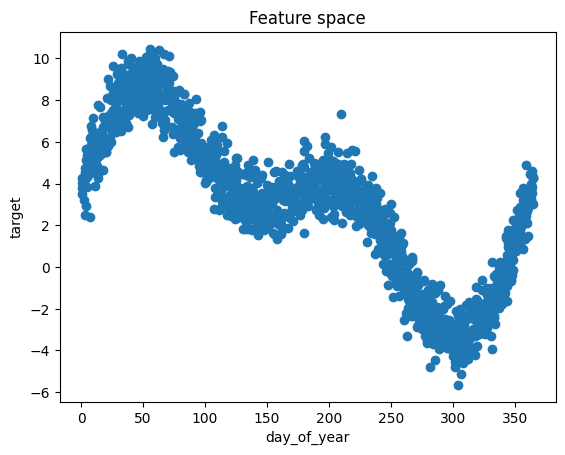

In [17]:
plt.scatter(df.day_of_year.values, df.y.values)
plt.xlabel('day_of_year')
plt.ylabel('target')
plt.title('Feature space')
plt.show();

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


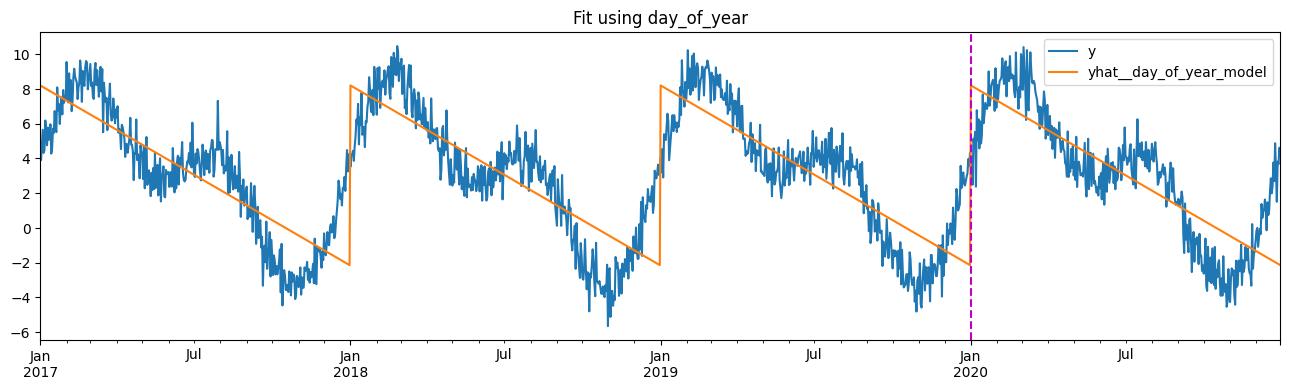

In [18]:
X_train = df[['day_of_year']].values
df["yhat__day_of_year_model"] = fit_predict(X_train)

make_forecast_plot(df, 'y', 'yhat__day_of_year_model', 'Fit using day_of_year')

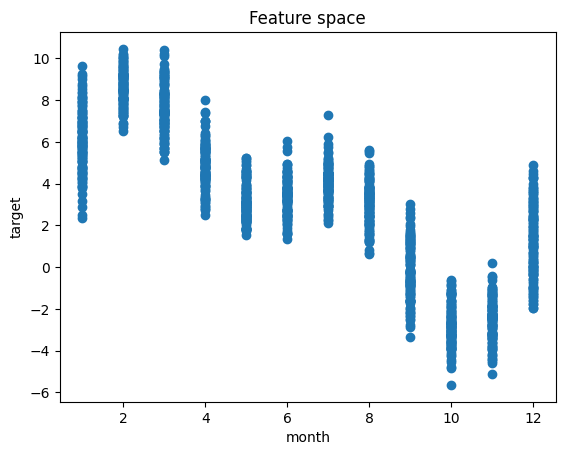

In [19]:
plt.scatter(df.index.month.values, df.y.values)
plt.xlabel('month')
plt.ylabel('target')
plt.title('Feature space')
plt.show();

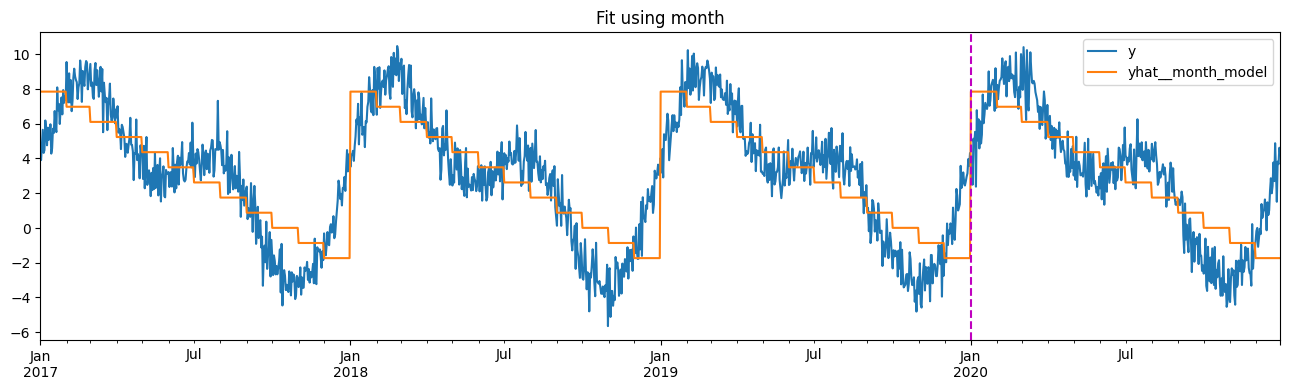

In [20]:
X_train = df.index.month.values.reshape(-1, 1)
df["yhat__month_model"] = fit_predict(X_train)

make_forecast_plot(df, 'y', 'yhat__month_model', 'Fit using month')

# Approach №1: dummy variables


In [21]:
X_train = pd.get_dummies(df.index.month, drop_first=True, prefix="month")

X_train.head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


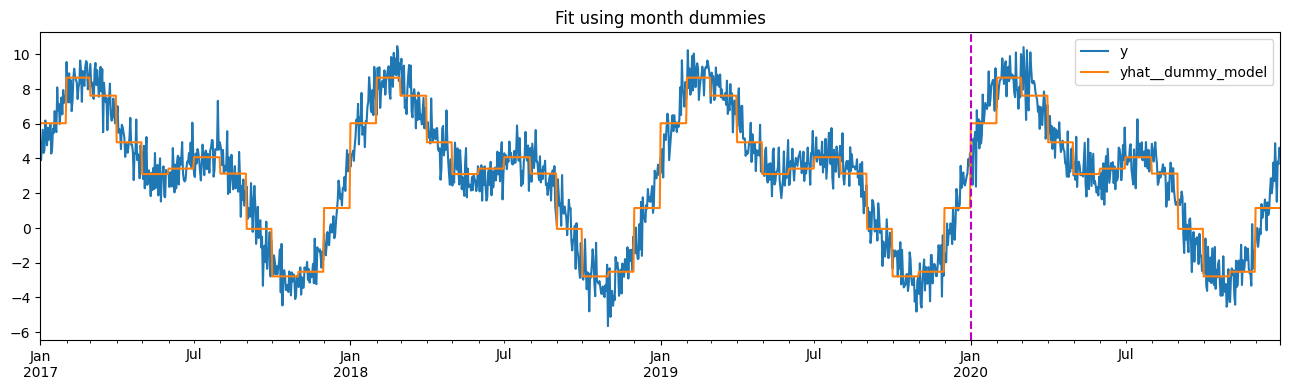

In [22]:
df["yhat__dummy_model"] = fit_predict(X_train)

make_forecast_plot(df, 'y', 'yhat__dummy_model', 'Fit using month dummies')

We can see step-like form of predicted values, because feature is dummy, and we got same value for entire month

But before proceeding it might be worth mentioning that when using non-linear models such as decision trees (or ensembles of thereof), we do not explicitly encode features such as month number or day of the year as dummies. Those models are capable of learning non-monotonic relationships between ordinal input features and the target.

# Approach №2: cyclical encoding with sine/cosine transformation

Imagine we are working with energy consumption data. When we include the information about the month of the observed consumption, it makes sense there is a stronger connection between two consecutive months. Using this logic, the connection between December and January and between January and February is strong. In comparison, the connection between January and July is not that strong. The same applies to other time-related information as well.

Some variables are of a circular nature. For example, the days of the year, 1-Jan-2019 (day 1) is just as close to 2-Jan-2019 (day 2) as it is to 31-Dec-2018 (day 365). If you would encode day of year numerically you would lose this information, as 1 close 2 to but far from 365. The repeating basis function transformer can remedy this problem.

In [23]:
harmonic_features = []
for period in [365, 365/2, 365/3, 365/4]:
    df[f'sine_p{int(period)}__day_of_year'] = calc_sine_feature(df['day_of_year'].values, period)
    df[f'cos_p{int(period)}__day_of_year'] = calc_cosine_feature(df['day_of_year'].values, period)
    harmonic_features.append(f'sine_p{int(period)}__day_of_year')
    harmonic_features.append(f'cos_p{int(period)}__day_of_year')
    
df[f'sine_p12__month'] = calc_sine_feature(df.index.month.values, 12)
df[f'cos_p12__month'] = calc_cosine_feature(df.index.month.values, 12)

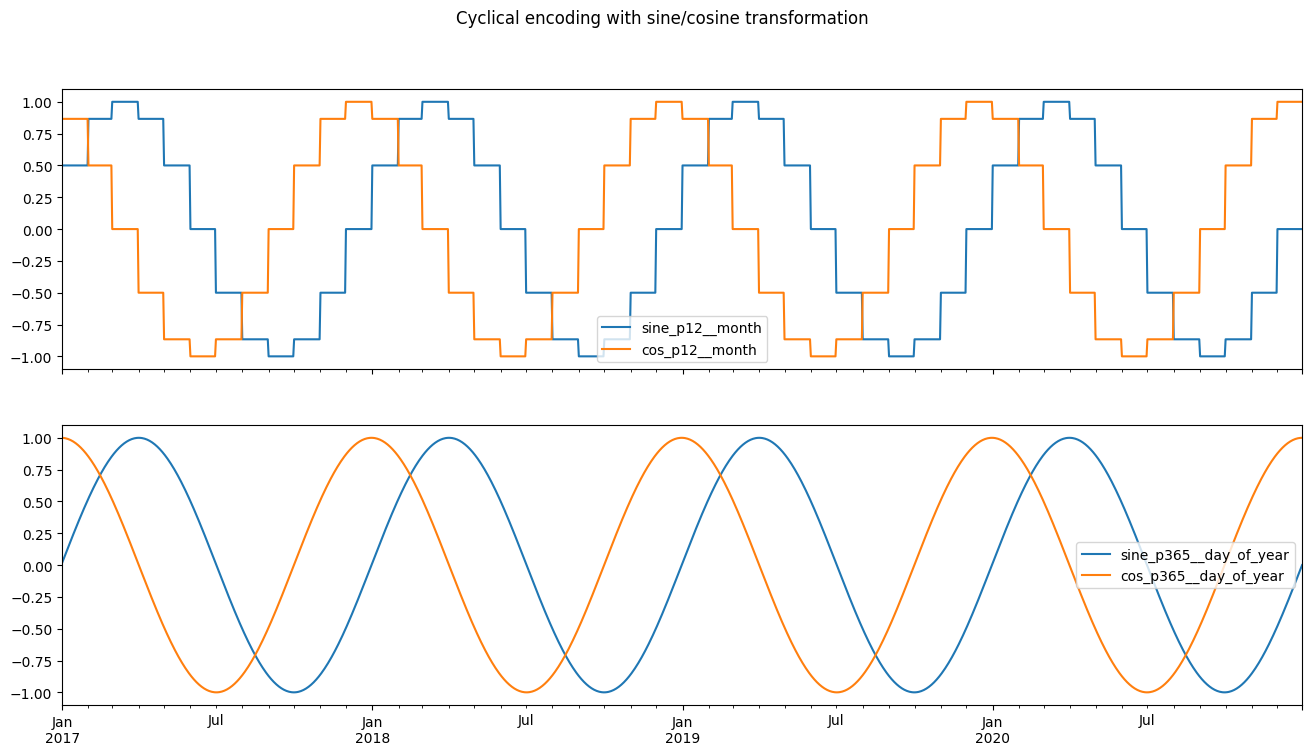

In [24]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,8))
df[["sine_p12__month", "cos_p12__month"]].plot(ax=ax[0])
df[["sine_p365__day_of_year", "cos_p365__day_of_year"]].plot(ax=ax[1])
plt.suptitle("Cyclical encoding with sine/cosine transformation");

Firstly, on the first plot we can easily see that the curves are step-wise when using the months for encoding but when using daily frequency, the curves are smooth;

Secondly, we can also see why we must use two curves instead of one. Due to the repetitive nature of the curves, if you drew a straight horizontal line through the plot for a single year, you would cross the curve in two places. This would not be enough for the model to understand the observation’s time point. But with the two curves, there is no such issue, and a user can identify every single time point.
This is clearly visible when we plot the values of the sine/cosine functions on a scatter plot. In the following figure we can see the circular pattern, with no overlapping values.

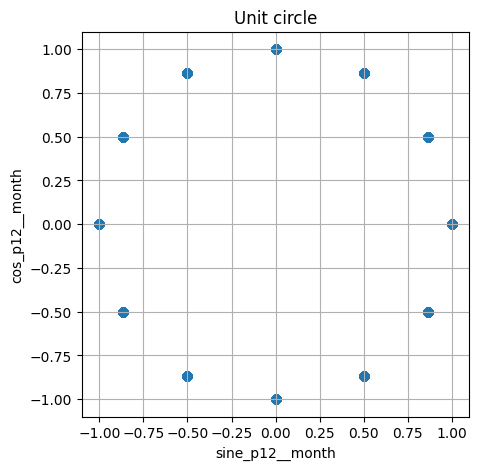

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(df['sine_p12__month'].values, df['cos_p12__month'].values)
plt.grid()
plt.xlabel('sine_p12__month')
plt.ylabel('cos_p12__month')
plt.title('Unit circle')
plt.show();

Let’s fit the same linear regression model using harmonic features coming from the daily frequency.

Firstly train model using only sine feature

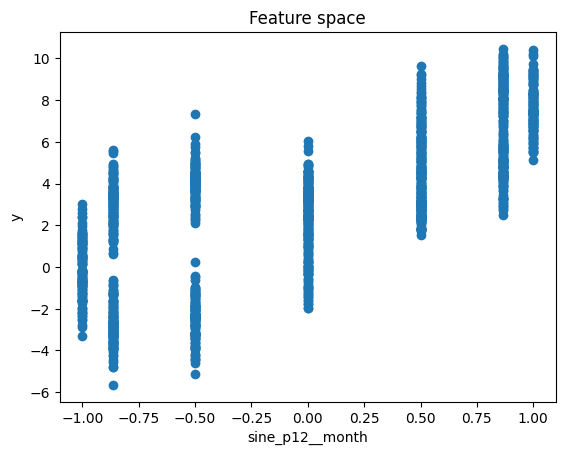

In [26]:
plt.scatter(df[["sine_p12__month"]].values, df.y.values)
plt.xlabel('sine_p12__month')
plt.ylabel('y')
plt.title('Feature space')
plt.show();

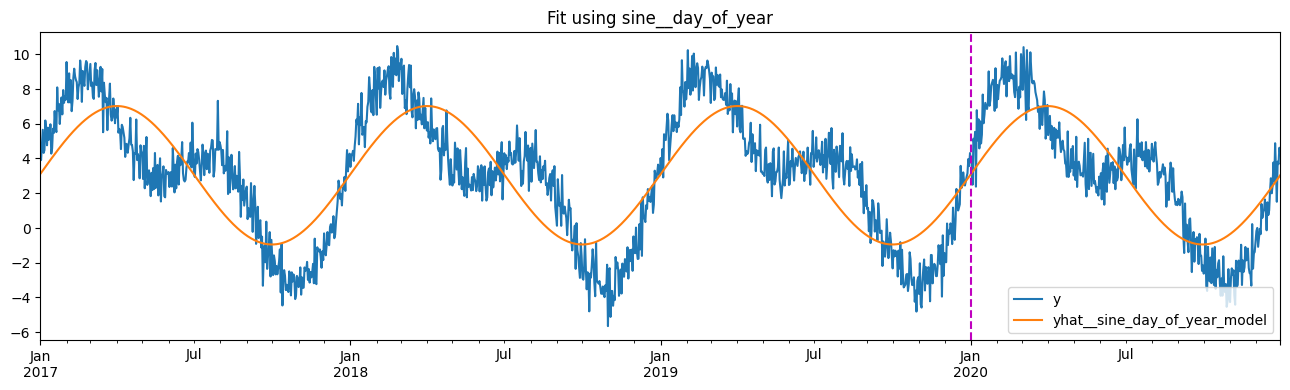

In [27]:
X_train = df[["sine_p365__day_of_year"]].values
df["yhat__sine_day_of_year_model"] = fit_predict(X_train)

make_forecast_plot(df, 'y', 'yhat__sine_day_of_year_model', 'Fit using sine__day_of_year')

Figures show that the model is able to pick up the general trend of the data, identifying periods with higher and lower values. However, it appears that the magnitude of the predictions is less accurate, and at a glance, this fit appears worse than the one achieved using dummy variables

Let's also train model using montly transformations

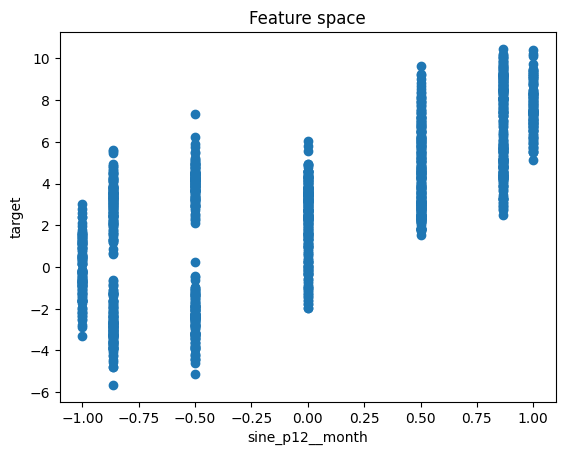

In [28]:
plt.scatter(df[["sine_p12__month"]].values, df.y.values)
plt.xlabel('sine_p12__month')
plt.ylabel('target')
plt.title('Feature space')
plt.show();

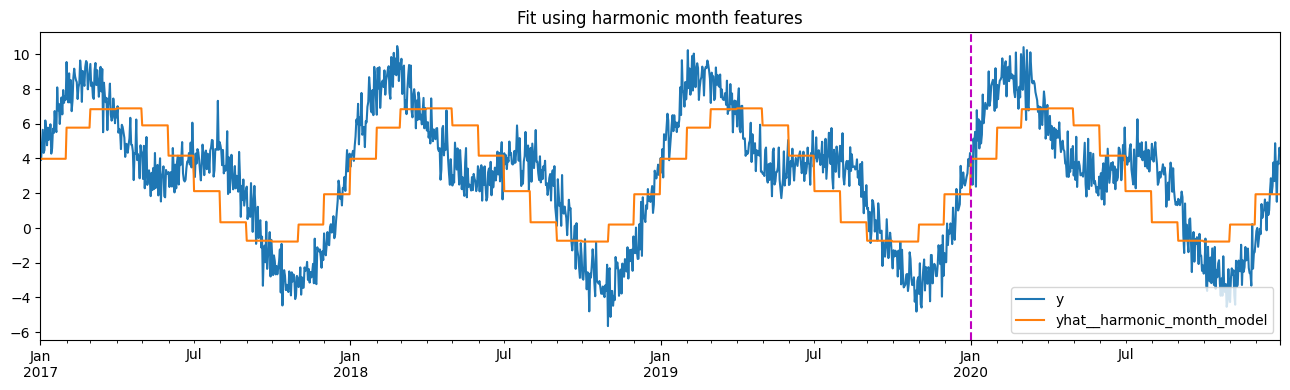

In [29]:
X_train = df[["sine_p12__month", "cos_p12__month"]].values
df["yhat__harmonic_month_model"] = fit_predict(X_train)

make_forecast_plot(df, 'y', 'yhat__harmonic_month_model', 'Fit using harmonic month features')

Train model using more harmonic features

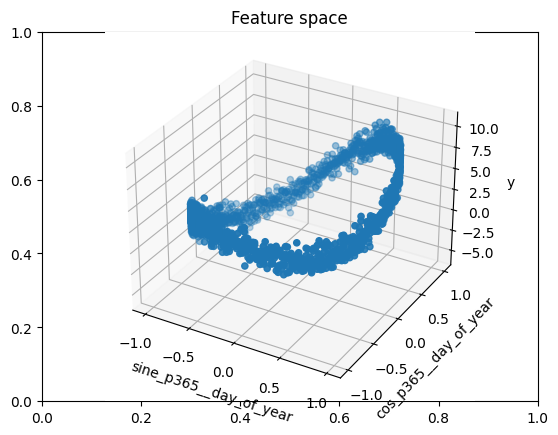

In [30]:
plt.figure()
plt.title('Feature space')
ax = plt.axes(projection='3d')
ax.scatter3D(df[["sine_p365__day_of_year"]].values,
             df[["cos_p365__day_of_year"]].values,
             df.y.values)
ax.set_xlabel('sine_p365__day_of_year')
ax.set_ylabel('cos_p365__day_of_year')
ax.set_zlabel('y')
plt.show()

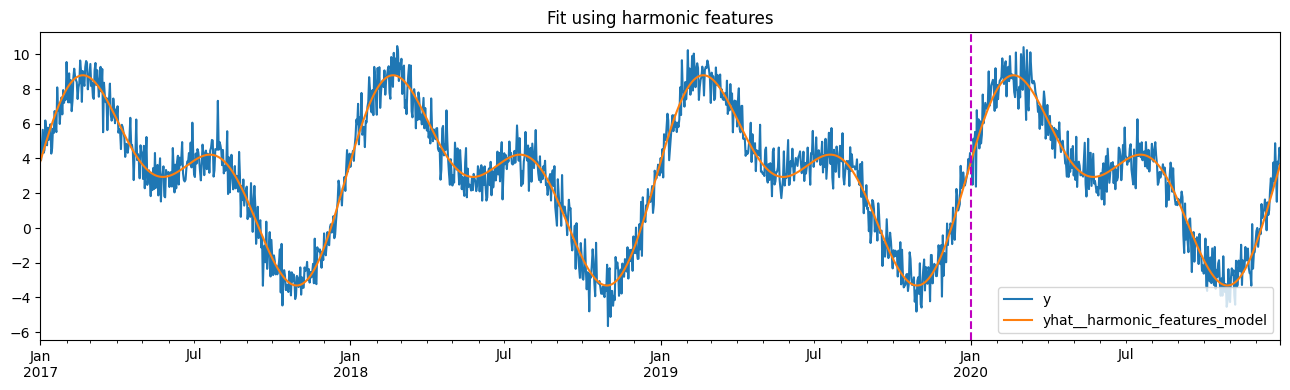

In [31]:
X_train = df[harmonic_features].values
df["yhat__harmonic_features_model"] = fit_predict(X_train)

make_forecast_plot(df, 'y', 'yhat__harmonic_features_model', 'Fit using harmonic features')

Using more periods lets model capture the data

It is worth mentioning that there is a serious drawback of this approach, which is apparent when using tree-based models. By design, the tree-based models make a split based on a single feature at the time. And as we have mentioned before, the sine/cosine features should be considered simultaneously in order to properly identify the time points within a period.

# Approach №3: radial basis functions


In [32]:
rbf_transformer = RepeatingBasisFunction(n_periods=12,
                                         column="day_of_year",
                                         input_range=(1, 365),
                                        )
X_train = rbf_transformer.fit_transform(df)
X_train = pd.DataFrame(index=df.index, data=X_train)

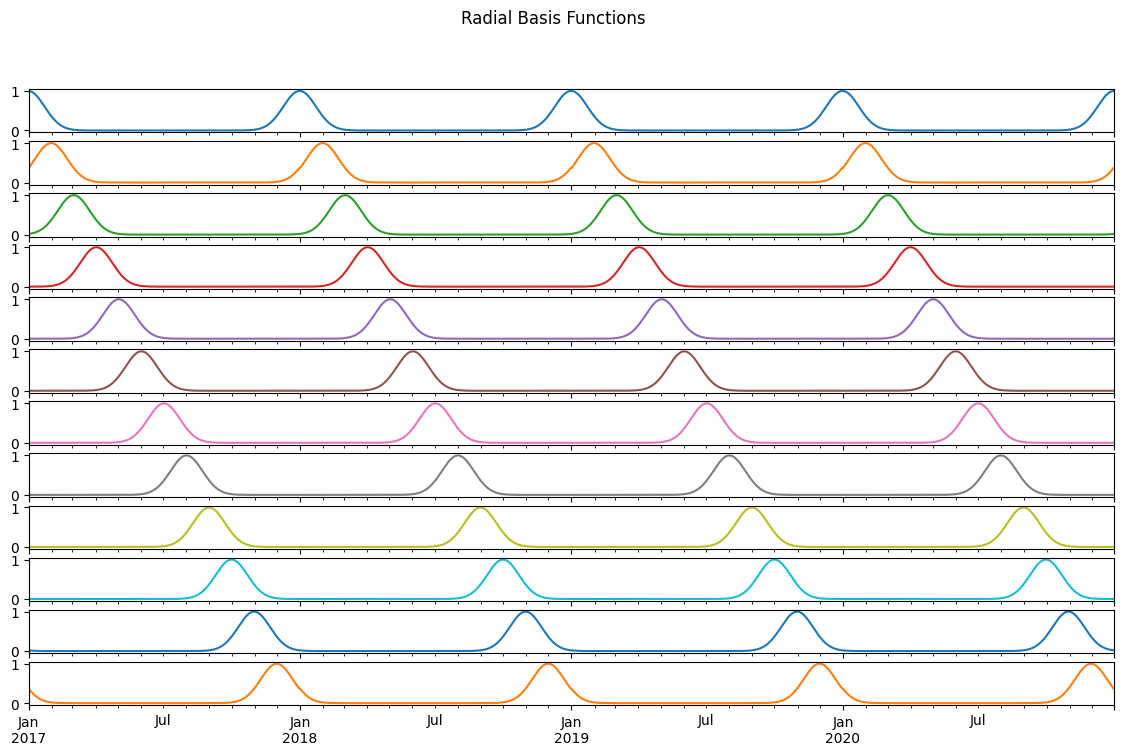

In [33]:
X_train.plot(subplots=True,
             figsize=(14, 8), 
             sharex=True,
             title="Radial Basis Functions",
             legend=False);

Figure shows the 12 radial basis functions that we have created using the day number as input. Each curve contains information about how close we are to a certain day of the year (because we chose that column). For example, the first curve measures distance from January 1, so it peaks on the first day of every year and decreases symmetrically as we move away from that date.

By design, the basis functions are equally spaced over the input range. We chose 12 as we wanted the RBFs to resemble months. This way, each function shows approximately (because of the months’ unequal length) the distance to the first day of the month.

Similar to the previous approaches, let’s fit the linear regression model using the 12 RBF features.

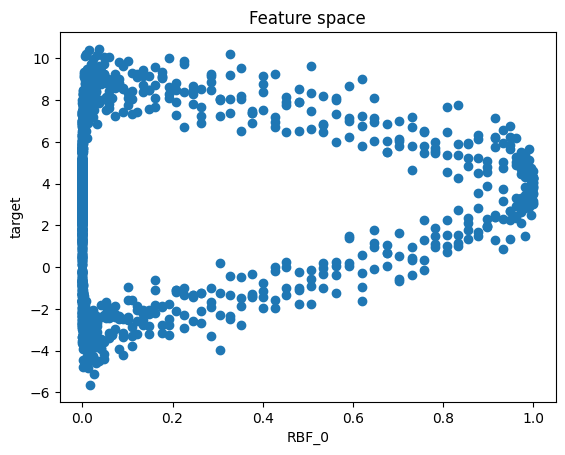

In [34]:
plt.scatter(X_train[0].values, df.y.values)
plt.xlabel('RBF_0')
plt.ylabel('target')
plt.title('Feature space')
plt.show();

Figure shows data representation in RBF_0 space. Points at right are days that close to 1st of January. Points at the extreme left are the rest days in year

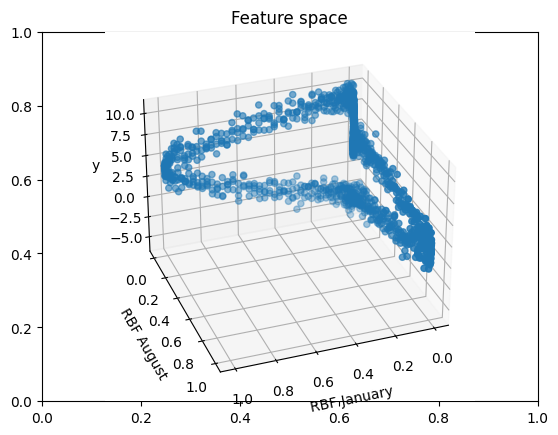

In [35]:
plt.figure()
plt.title('Feature space')
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[0].values,
             X_train[8].values,
             df.y.values)
ax.set_xlabel('RBF January')
ax.set_ylabel('RBF August')
ax.set_zlabel('y')
ax.azim = 70
plt.show()

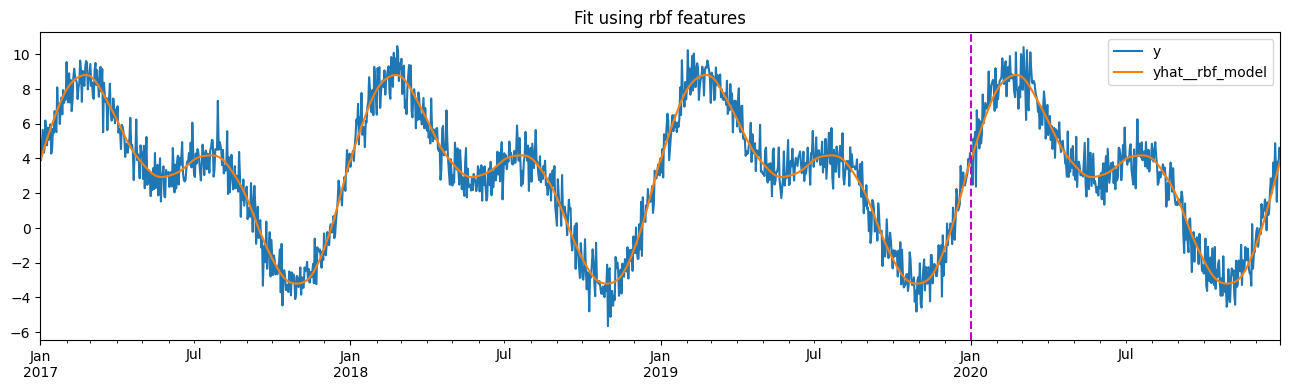

In [36]:
df["yhat__rbf_model"] = fit_predict(X_train)

make_forecast_plot(df, 'y', 'yhat__rbf_model', 'Fit using rbf features')

There are two key parameters that we can tune when using radial basis functions:

the number of the radial basis functions,
the shape of the bell curves – it can be modified with the width argument of RepeatingBasisFunction.
One method for tuning these parameter values would be to use grid search to identify the optimal values for a given data set.

# Results

In [37]:
comparison_cols = ['y',
                   'yhat__dummy_model',
                   'yhat__harmonic_month_model',
                    'yhat__harmonic_features_model',
                   'yhat__rbf_model',
                  ]

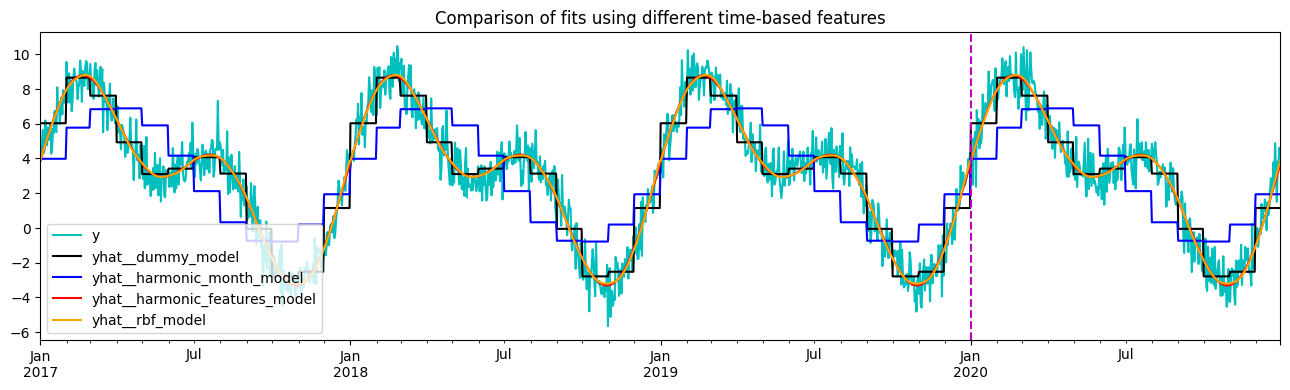

In [38]:
df[comparison_cols].plot(title="Comparison of fits using different time-based features",
                         figsize=(16,4),
                         color = ["c", "k", "b", "r", "orange"])
plt.axvline(date(2020, 1, 1), c="m", linestyle="--");

Figure illustrates that the harmonic features and RBF resulted in the closest fit from the considered approaches. The sine/cosine features of month allowed the model to pick up the main patterns but were not enough to capture the dynamics of the series entirely.

Using the snippet below, we calculate the Mean Absolute Error for each of the models, over both training and test sets. We expect the scores to be very similar between training and test sets, as the generated series is almost perfectly cyclical – the only difference between the years is the random component.

Naturally, that would not be the case in a real-life situation, in which we would encounter much more variability between the same periods over time. However, in such cases, we would also use many other features (for example, some measure of trend or the passage of time) to account for those changes.

In [39]:
forecast_cols = ['yhat__dummy_model',
                 'yhat__sine_day_of_year_model',
                 'yhat__harmonic_month_model',
                 'yhat__harmonic_features_model',
                 'yhat__day_of_year_model',
                 'yhat__month_model', 
                 'yhat__rbf_model']

In [40]:
score_list = []
for forecast in forecast_cols:
    scores = {
        "model": forecast,
        "train_score": mean_absolute_error(
            df.iloc[:TRAIN_END]["y"],
            df.iloc[:TRAIN_END][forecast]
        ),
        "test_score": mean_absolute_error(
            df.iloc[TRAIN_END:]["y"],
            df.iloc[TRAIN_END:][forecast]
        )
    }
    score_list.append(scores)

scores_df = pd.DataFrame(score_list).sort_values(by='test_score').reset_index(drop=True)
scores_df

,model,train_score,test_score
0,yhat__rbf_model,0.657744,0.692134
1,yhat__harmonic_features_model,0.659334,0.692215
2,yhat__dummy_model,0.876548,0.925758
3,yhat__day_of_year_model,1.646968,1.664292
4,yhat__month_model,1.654016,1.676960
5,yhat__sine_day_of_year_model,1.976117,1.990150
6,yhat__harmonic_month_model,1.999348,2.009588


As before, we can see that the model using RBF features resulted in the best fit, while the sine/cosine features of month performed the worst. Our assumption about the similarity of the scores between the training and test sets was also confirmed.